# Advanced Linear Regession Assignment - Surprise Housing

It is required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

###### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import calendar

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

### Reading the data

In [2]:
data = pd.read_csv('train.csv')
print(data.shape)
data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Missing Data treatment

In [3]:
def check_missing_data():
    missing_data = [i for i in data.isna().mean().items() if i[1] > 0]
    missing_data.sort(key=lambda e:e[1], reverse=True)
    print(missing_data)
    
check_missing_data()

[('PoolQC', 0.9952054794520548), ('MiscFeature', 0.963013698630137), ('Alley', 0.9376712328767123), ('Fence', 0.8075342465753425), ('MasVnrType', 0.5972602739726027), ('FireplaceQu', 0.4726027397260274), ('LotFrontage', 0.1773972602739726), ('GarageType', 0.05547945205479452), ('GarageYrBlt', 0.05547945205479452), ('GarageFinish', 0.05547945205479452), ('GarageQual', 0.05547945205479452), ('GarageCond', 0.05547945205479452), ('BsmtExposure', 0.026027397260273973), ('BsmtFinType2', 0.026027397260273973), ('BsmtQual', 0.025342465753424658), ('BsmtCond', 0.025342465753424658), ('BsmtFinType1', 0.025342465753424658), ('MasVnrArea', 0.005479452054794521), ('Electrical', 0.0006849315068493151)]


There are lot of columns with missing values. We will drop the columns with >40% null values

In [4]:
data.drop(columns=[i[0] for i in data.isna().mean().items() if i[1] > 0.4], axis=1, inplace=True)
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


###### Missing data check again

In [5]:
check_missing_data()

[('LotFrontage', 0.1773972602739726), ('GarageType', 0.05547945205479452), ('GarageYrBlt', 0.05547945205479452), ('GarageFinish', 0.05547945205479452), ('GarageQual', 0.05547945205479452), ('GarageCond', 0.05547945205479452), ('BsmtExposure', 0.026027397260273973), ('BsmtFinType2', 0.026027397260273973), ('BsmtQual', 0.025342465753424658), ('BsmtCond', 0.025342465753424658), ('BsmtFinType1', 0.025342465753424658), ('MasVnrArea', 0.005479452054794521), ('Electrical', 0.0006849315068493151)]


###### Imputing 'LotFrontage' column with mean value of the column

In [6]:
data['LotFrontage'] = data['LotFrontage'].fillna(data['LotFrontage'].quantile(0.5))

###### Imputing 'GarageType' column with 'NoGarage' (since it means that there is no Garage as per data dictionary)
###### Also inputing 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond' where the 'GarageType' not present

In [7]:
data.loc[data['GarageType'].isna(), ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']] = ['NoGarage', 0, 'NA', 'NA', 'NA']

###### Imputing 'BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1' where basement is not available

In [8]:
for col in ['BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']:
    data.loc[data[col].isna(), col] = 'NA'

###### Imputing 'MasVnrArea'

In [9]:
data['MasVnrArea'] = data['MasVnrArea'].fillna(0)

###### Imputing 'Electrical'

In [10]:
data['Electrical'] = data['Electrical'].fillna('NA')

###### Checking for null values again

In [11]:
data.isna().sum().sum()

0

###### Converting 'MSSubClass' to a categorical variable

In [12]:
def convert_to_categorical_variable(col, map):
    data[col] = data[col].apply(lambda x: map.get(x))

ms_sub_class_map = {20:'1-STORY-1946-NEWER-ALL-STYLES',
30:'1-STORY-1945-OLDER',
40:'1-STORY-W-FINISHED-ATTIC-ALL-AGES',
45:'1-1-2-STORY-UNFINISHED-ALL-AGES',
50:'1-1-2-STORY-FINISHED-ALL-AGES',
60:'2-STORY-1946-NEWER',
70:'2-STORY-1945-OLDER',
75:'2-1-2-STORY-ALL-AGES',
80:'SPLIT-OR-MULTI-LEVEL',
85:'SPLIT-FOYER',
90:'DUPLEX-ALL-STYLES-AND-AGES',
120:'1-STORY-PUD-1946-NEWER',
150:'1-1-2-STORY-PUD-ALL-AGES',
160:'2-STORY-PUD-1946-NEWER',
180:'PUD-MULTILEVEL-INCL-SPLIT-LEV-FOYER',
190:'2-FAMILY-CONVERSION-ALL-STYLES-AND-AGES'
}


convert_to_categorical_variable('MSSubClass', ms_sub_class_map)

data['MSSubClass'].value_counts()

MSSubClass
1-STORY-1946-NEWER-ALL-STYLES              536
2-STORY-1946-NEWER                         299
1-1-2-STORY-FINISHED-ALL-AGES              144
1-STORY-PUD-1946-NEWER                      87
1-STORY-1945-OLDER                          69
2-STORY-PUD-1946-NEWER                      63
2-STORY-1945-OLDER                          60
SPLIT-OR-MULTI-LEVEL                        58
DUPLEX-ALL-STYLES-AND-AGES                  52
2-FAMILY-CONVERSION-ALL-STYLES-AND-AGES     30
SPLIT-FOYER                                 20
2-1-2-STORY-ALL-AGES                        16
1-1-2-STORY-UNFINISHED-ALL-AGES             12
PUD-MULTILEVEL-INCL-SPLIT-LEV-FOYER         10
1-STORY-W-FINISHED-ATTIC-ALL-AGES            4
Name: count, dtype: int64

### Exploratory Data Analysis

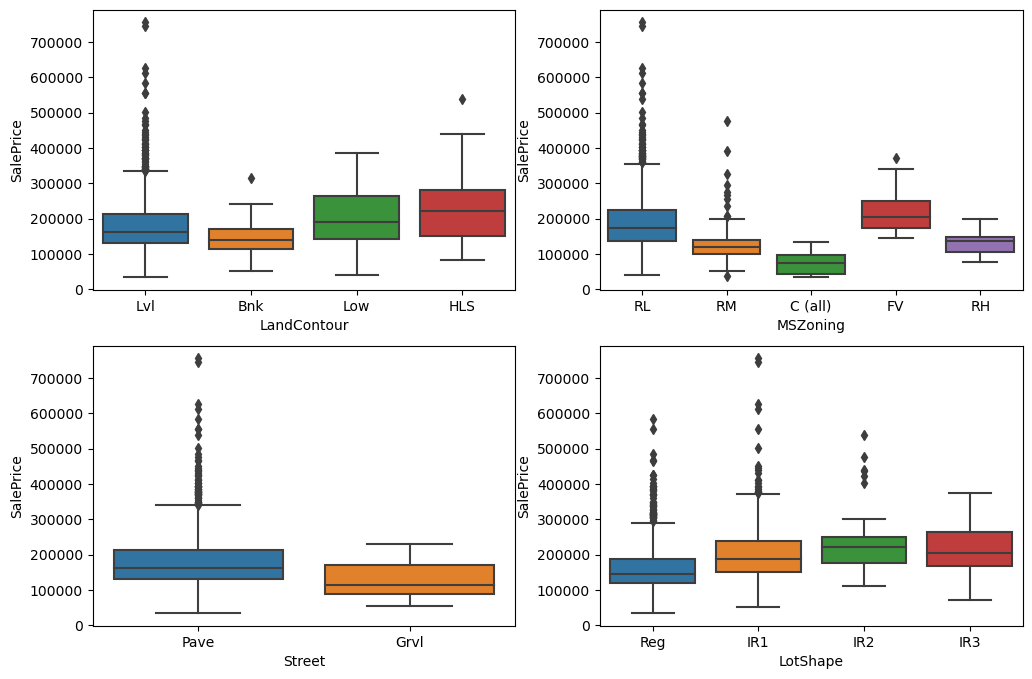

In [24]:
#data['MSSubClass'].value_counts()

#sns.boxplot(x='MSSubClass', y='SalePrice', data=data)
#plt.xticks(rotation=90)

fig, axes = plt.subplots(2, 2, figsize=(12,8))

sns.boxplot(ax=axes[0][0], data=data, x='LandContour', y='SalePrice')

sns.boxplot(ax=axes[0][1], data=data, x='MSZoning', y='SalePrice')

sns.boxplot(ax=axes[1][0], data=data, x='Street', y='SalePrice')

sns.boxplot(ax=axes[1][1], data=data, x='LotShape', y='SalePrice')

plt.show()

- **Land Countour**: **Hillside** property has the higher median sale price whereas **Banked** property has a lower median sale price.
- **MSZoning**: **Floating Village Residential** property has higher median sale price whereas **Commercial** has lower median sale price
- **Street**: Properties having **Paved** access have higher median price than **Gravel** access.
- **LotShape**: Properties having **Regular** shape are priced lower and **Moderately Irregular** properties are priced Higher.

In [23]:
data['MSZoning'].value_counts()

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64